# Domain Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sys
sys.path.append("../..")

In [2]:
from collections import defaultdict
import ipaddress
import os.path

import matplotlib
import networkx as nx

matplotlib.rcParams['figure.figsize'] = (9.5, 8)

## Load Full DNS Graph

In [3]:
from netanalysis.analysis.analysis_app import AnalysisApp

app = AnalysisApp(os.path.join(os.getcwd(), "..", "..", "ooni_data"))

IntProgress(value=0, description='Loading')

## Create Domain Graph

In [4]:
domain_app = app.domain_app("www.cnn.com")
print("Graph nodes: %s" % ", ".join(sorted(domain_app.domain_graph.nodes)))
print("Parent domains: %s" % (set(nx.dfs_preorder_nodes(app.dns_graph.reverse(copy=False), domain_app.domain)) - set([domain_app.domain])))

Graph nodes: 0.0.0.0/24, 107.6.165.0/24, 107.6.183.0/24, 151.101.0.0/24, 151.101.1.0/24, 151.101.100.0/24, 151.101.105.0/24, 151.101.112.0/24, 151.101.113.0/24, 151.101.117.0/24, 151.101.12.0/24, 151.101.120.0/24, 151.101.121.0/24, 151.101.125.0/24, 151.101.128.0/24, 151.101.129.0/24, 151.101.13.0/24, 151.101.132.0/24, 151.101.133.0/24, 151.101.137.0/24, 151.101.140.0/24, 151.101.141.0/24, 151.101.16.0/24, 151.101.165.0/24, 151.101.17.0/24, 151.101.173.0/24, 151.101.177.0/24, 151.101.185.0/24, 151.101.189.0/24, 151.101.192.0/24, 151.101.193.0/24, 151.101.197.0/24, 151.101.20.0/24, 151.101.201.0/24, 151.101.205.0/24, 151.101.209.0/24, 151.101.21.0/24, 151.101.225.0/24, 151.101.229.0/24, 151.101.24.0/24, 151.101.25.0/24, 151.101.29.0/24, 151.101.32.0/24, 151.101.33.0/24, 151.101.36.0/24, 151.101.37.0/24, 151.101.4.0/24, 151.101.40.0/24, 151.101.41.0/24, 151.101.44.0/24, 151.101.49.0/24, 151.101.5.0/24, 151.101.53.0/24, 151.101.56.0/24, 151.101.57.0/24, 151.101.60.0/24, 151.101.61.0/24, 1

## Classify Edges

<IPython.core.display.Javascript object>


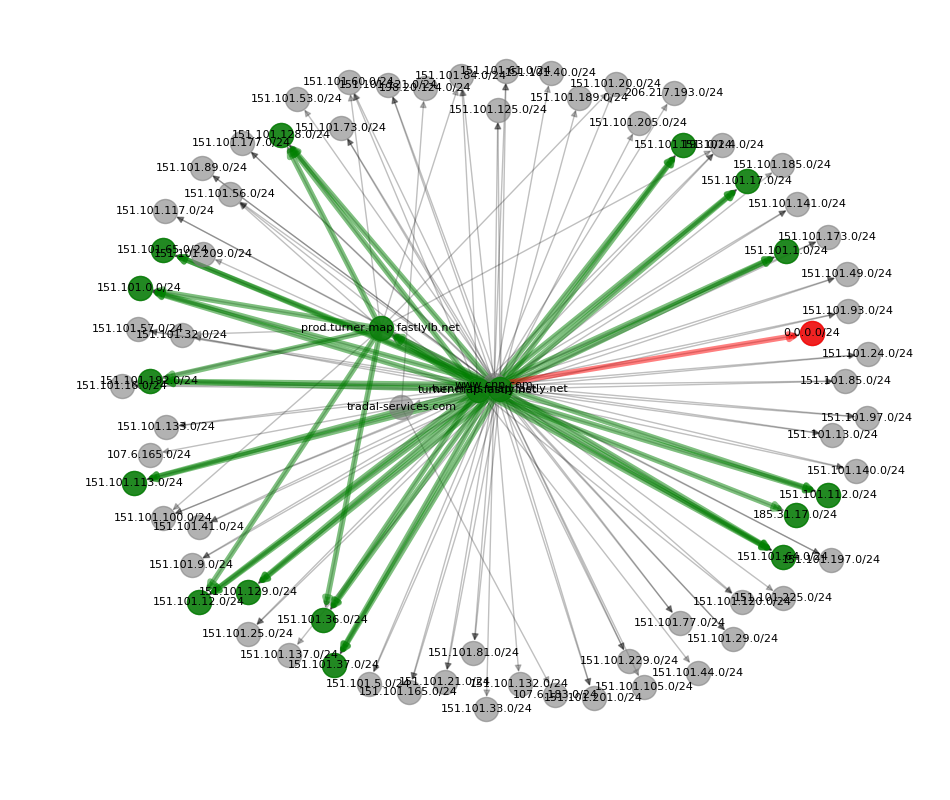

In [5]:
domain_app.display_graph()

## Use TLS to verify UNKNOWNs

At this stage we use TLS validation of certificates to check if an IP is valid for a domain

Checking IPs for www.cnn.com - 107.6.165.0/24
    Validating 107.6.165.75: SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:748)')
Checking IPs for www.cnn.com - 107.6.183.0/24
    Validating 107.6.183.147: SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:748)')
Checking IPs for www.cnn.com - 151.101.100.0/24
    Validating 151.101.100.73: ConnectionResetError(104, 'Connection reset by peer')
Checking IPs for www.cnn.com - 151.101.105.0/24
    Validating 151.101.105.67: VALID
Checking IPs for www.cnn.com - 151.101.117.0/24
    Validating 151.101.117.67: VALID
Checking IPs for www.cnn.com - 151.101.120.0/24
    Validating 151.101.120.73: ConnectionResetError(104, 'Connection reset by peer')
Checking IPs for www.cnn.com - 151.101.121.0/24
    Validating 151.101.121.67: VALID
Checking IPs for www.cnn.com - 151.101.125.0/24
    Validating 151.101.125.67: VALID
Checking IPs for www.cnn.com - 151.101.13.0/24
    Validating 151.101

    Validating 151.101.60.73: ConnectionResetError(104, 'Connection reset by peer')
Checking IPs for prod.turner.map.fastlylb.net - 151.101.84.0/24
    Validating 151.101.84.73: ConnectionResetError(104, 'Connection reset by peer')


<IPython.core.display.Javascript object>


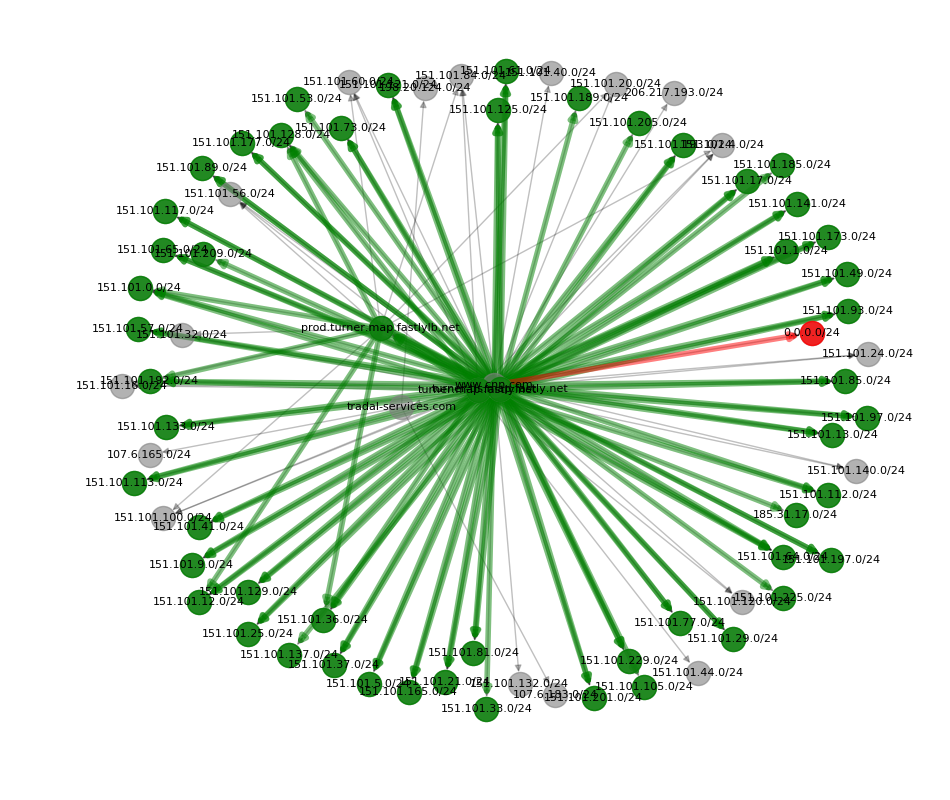

In [6]:
domain_app.tls_verify_unknowns()
domain_app.display_graph()

## Classify Measurements

In [7]:
from netanalysis.dns import classifier as dc

def analyze_measurements(domain: str, domain_graph, class_graph, results=None):
    measurements = dict()  # type: Dict[str, dns.DnsMeasurement]
    for u, v, data in domain_graph.edges(data=True):
        measurement = data.get("measurement")
        if not measurement:
            continue
        if measurement.trust_reason:
            continue
        if measurement.records[0].name.lower() != domain:
            continue
        measurements[measurement.measurement_id] = measurement


    for measurement in sorted(measurements.values(), key=lambda m: m.time):
        measurement_eval = dc.Evaluation(dc.EdgeClass.UNKNOWN, None)
        ips = []
        for record in measurement.records:
            try:
                ip = record.data.ip
                ips.append(ip)
            except AttributeError:
                continue
            
        for ip in ips:
            net = str(ipaddress.ip_network(ip).supernet(new_prefix=24))
            evaluation = class_graph[domain][net]["eval"]
            if evaluation.classification != dc.EdgeClass.UNKNOWN:
                measurement_eval = evaluation
                break
        if not results or measurement_eval.classification in results:
            print("{} {} {}, IPs: [{}] (DNS: {})".format(
                measurement.time,
                measurement.client_country,
                measurement_eval.classification.name,
                ", ".join(str(ip) for ip in ips),
                measurement.resolver_ip
            ))

analyze_measurements(domain_app.domain,
                     domain_app.domain_graph,
                     domain_app.classifier.class_graph,
                     results=[dc.EdgeClass.UNKNOWN, dc.EdgeClass.BAD])

2016-06-22 01:27:21 GY UNKNOWN, IPs: [151.101.56.73] (DNS: 190.80.8.14)
2016-06-23 14:49:31 GY UNKNOWN, IPs: [151.101.56.73] (DNS: 190.80.8.16)
2016-06-23 19:51:37 CU UNKNOWN, IPs: [151.101.56.73] (DNS: 190.6.81.246)
2016-06-25 10:59:52 GY UNKNOWN, IPs: [151.101.56.73] (DNS: 190.80.8.13)
2016-06-26 14:15:12 GY UNKNOWN, IPs: [151.101.56.73] (DNS: 190.80.8.13)
2016-06-30 10:16:11 GY UNKNOWN, IPs: [151.101.56.73] (DNS: 190.80.8.13)
2016-07-01 12:07:35 GY UNKNOWN, IPs: [151.101.32.73] (DNS: 190.80.8.13)
2016-07-03 15:58:36 CO UNKNOWN, IPs: [151.101.32.73] (DNS: 200.75.51.135)
2016-07-04 11:19:36 GY UNKNOWN, IPs: [151.101.32.73] (DNS: 190.80.8.14)
2016-07-14 01:54:24 SR UNKNOWN, IPs: [151.101.56.73] (DNS: 200.1.156.162)
2016-07-14 05:06:59 SR UNKNOWN, IPs: [151.101.56.73] (DNS: 200.1.156.162)
2016-07-14 17:04:29 SR UNKNOWN, IPs: [151.101.56.73] (DNS: 200.1.156.163)
2016-07-16 05:34:30 SR UNKNOWN, IPs: [151.101.56.73] (DNS: 200.1.156.163)
2016-07-16 10:17:45 SR UNKNOWN, IPs: [151.101.56.73] 

2018-02-26 01:19:20 US BAD, IPs: [0.0.0.0] (DNS: 74.125.44.85)
2018-02-27 01:18:11 US BAD, IPs: [0.0.0.0] (DNS: 74.125.44.142)
2018-02-27 01:18:11 US BAD, IPs: [0.0.0.0] (DNS: 74.125.44.142)


## Analyze a country

<IPython.core.display.Javascript object>


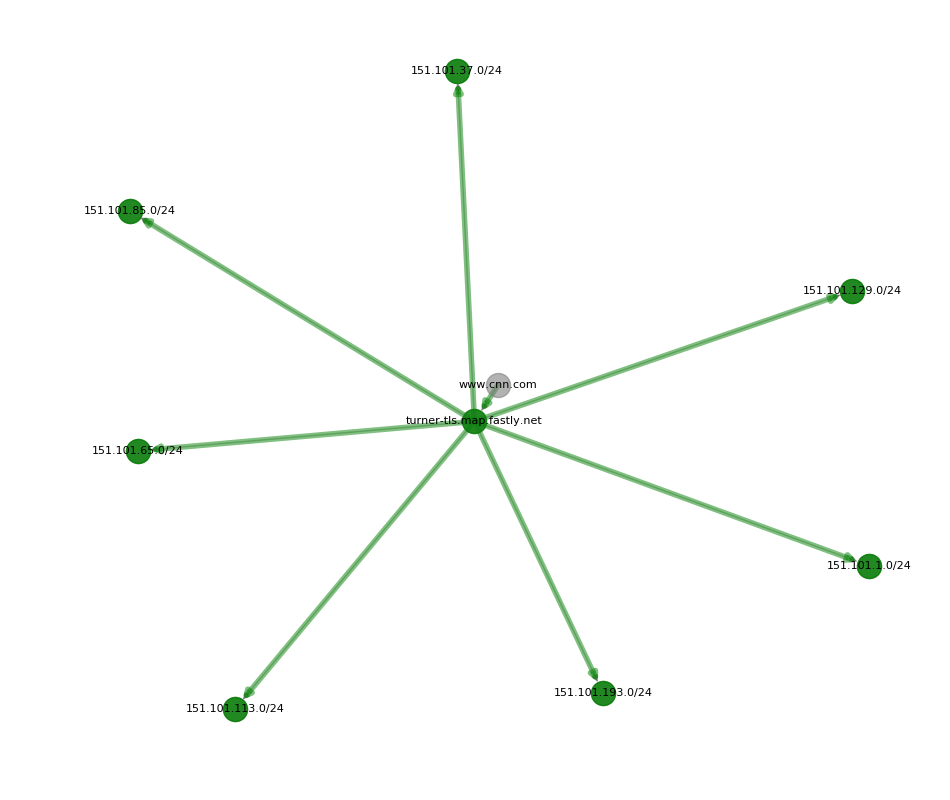

In [8]:
domain_app.display_graph(country="RU")

## Investigate an IP Address

In [9]:
from IPython.display import display
import ipywidgets as widgets
from netanalysis.analysis import ip_info_widget
from netanalysis.ip import ip_info as ii

ip_info = ii.create_default_ip_info_service()
ip_tab = ip_info_widget.create_ip_info_widget(ip_info)
tabs = widgets.Tab()
tabs.set_title(0, "IP Info")
tabs.children = [ip_tab]
tabs

Tab(children=(VBox(children=(HBox(children=(Text(value='', description='IP', placeholder='Enter ip address'), Button(description='Get info', style=ButtonStyle()))), Output())),), _titles={'0': 'IP Info'})